Задача
1. Сгенерируйте набор данных для предсказания временных последовательностей. Выполните тренировку RNN
2. Модифицируйте сеть, используя в качестве рекуррентного слоя LSTM слой библиотеки pytorch.
https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

3. решите задачу набора данных лекции 7.

In [17]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

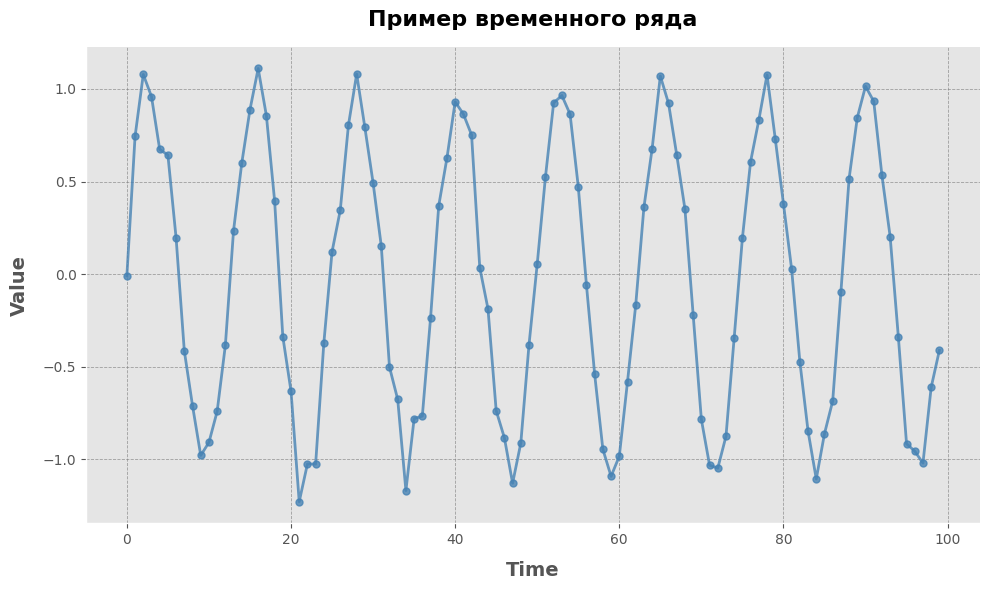

In [13]:
def generate_sine_wave(seq_length=100, num_sequences=1000):
    x = np.linspace(0, 50, seq_length)
    y = np.sin(x) + np.random.normal(0, 0.1, size=(num_sequences, seq_length))  # Добавляем шум
    return y

data = generate_sine_wave(seq_length=100, num_sequences=1000)

data_tensor = torch.tensor(data, dtype=torch.float32)

plt.style.use('ggplot')  
plt.figure(figsize=(10, 6))
plt.plot(data[0], color='steelblue', linewidth=2, linestyle='-', marker='o', markersize=5, alpha=0.8)
plt.xlabel("Time", fontsize=14, fontweight='bold', labelpad=10)
plt.ylabel("Value", fontsize=14, fontweight='bold', labelpad=10)
plt.title("Пример временного ряда", fontsize=16, fontweight='bold', pad=15)
plt.grid(color='gray', linestyle='--', linewidth=0.6, alpha=0.7)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

In [14]:
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Используем последний выход RNN
        return out

# Делаем данные в формате (batch_size, sequence_length, input_size)
input_data = data_tensor[:, :-1].unsqueeze(-1) 
target_data = data_tensor[:, -1].unsqueeze(-1)

train_size = int(0.8 * len(data))
train_data, test_data = input_data[:train_size], input_data[train_size:]
train_target, test_target = target_data[:train_size], target_data[train_size:]

model_rnn = RNNModel(input_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=0.001)

epochs = 100
for epoch in range(epochs):
    model_rnn.train()
    optimizer.zero_grad()
    
    output = model_rnn(train_data)
    loss = criterion(output, train_target)
    
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")

model_rnn.eval()
with torch.no_grad():
    predictions = model_rnn(test_data)
    test_loss = criterion(predictions, test_target)
    print(f"Test Loss: {test_loss.item()}")

Epoch 0/100, Loss: 0.2059653103351593
Epoch 10/100, Loss: 0.027459073811769485
Epoch 20/100, Loss: 0.012022954411804676
Epoch 30/100, Loss: 0.011911313980817795
Epoch 40/100, Loss: 0.011605534702539444
Epoch 50/100, Loss: 0.01092712301760912
Epoch 60/100, Loss: 0.010908884927630424
Epoch 70/100, Loss: 0.010914567857980728
Epoch 80/100, Loss: 0.010888388380408287
Epoch 90/100, Loss: 0.010877365246415138
Test Loss: 0.009554389864206314


In [15]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Используем последний выход LSTM
        return out

model_lstm = LSTMModel(input_size=1)
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)

for epoch in range(epochs):
    model_lstm.train()
    optimizer.zero_grad()
    
    output = model_lstm(train_data)
    loss = criterion(output, train_target)
    
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")

model_lstm.eval()
with torch.no_grad():
    predictions = model_lstm(test_data)
    test_loss = criterion(predictions, test_target)
    print(f"Test Loss (LSTM): {test_loss.item()}")

Epoch 0/100, Loss: 0.05813996493816376
Epoch 10/100, Loss: 0.012845239602029324
Epoch 20/100, Loss: 0.013504824601113796
Epoch 30/100, Loss: 0.011026928201317787
Epoch 40/100, Loss: 0.011084424331784248
Epoch 50/100, Loss: 0.010909177362918854
Epoch 60/100, Loss: 0.010850268416106701
Epoch 70/100, Loss: 0.01086045429110527
Epoch 80/100, Loss: 0.010846218094229698
Epoch 90/100, Loss: 0.010844706557691097
Test Loss (LSTM): 0.009584478102624416


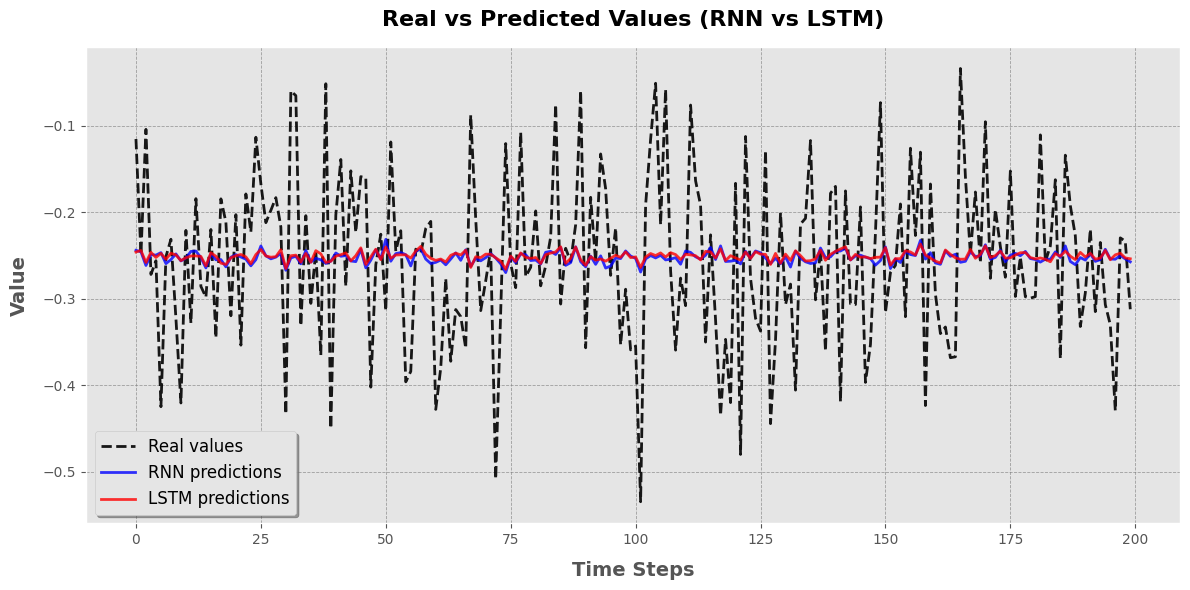

In [16]:
import matplotlib.pyplot as plt

model_rnn.eval()
with torch.no_grad():
    rnn_predictions = model_rnn(test_data)

model_lstm.eval()
with torch.no_grad():
    lstm_predictions = model_lstm(test_data)

# Преобразуем предсказания и реальные значения в Python списки для удобства визуализации
rnn_predictions = rnn_predictions.squeeze().tolist()
lstm_predictions = lstm_predictions.squeeze().tolist()
test_target = test_target.squeeze().tolist()

plt.style.use('ggplot')

plt.figure(figsize=(12, 6))
plt.plot(test_target, label='Real values', color='black', linestyle='--', linewidth=2, alpha=0.9)
plt.plot(rnn_predictions, label='RNN predictions', color='blue', linestyle='-', linewidth=2, alpha=0.8)
plt.plot(lstm_predictions, label='LSTM predictions', color='red', linestyle='-', linewidth=2, alpha=0.8)

plt.title('Real vs Predicted Values (RNN vs LSTM)', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Time Steps', fontsize=14, fontweight='bold', labelpad=10)
plt.ylabel('Value', fontsize=14, fontweight='bold', labelpad=10)
plt.legend(fontsize=12, loc='best', frameon=True, shadow=True)
plt.grid(color='gray', linestyle='--', linewidth=0.6, alpha=0.7)
plt.tight_layout()
plt.show()


Из лекции 7
Задание (файл 2)
Разделить данные на N групп. (возможно, выбрать первые M данных для обучения)
Реализовать предсказание ARIMA для 2 (тренировочной группы) на основе 1. Рассчитать MSE.
Исследовать качество работы модели в зависимости от параметров (для групп 1-2).
(1)Выполнить итеративное предсказание, данные для каждого следующего предсказания обновлять по методу
"экспоненциальное среднее".

In [18]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error


--- Модель ARIMA для группы 1 ---
Ошибка MSE для модели ARIMA(1,0,0): 5.7036246443


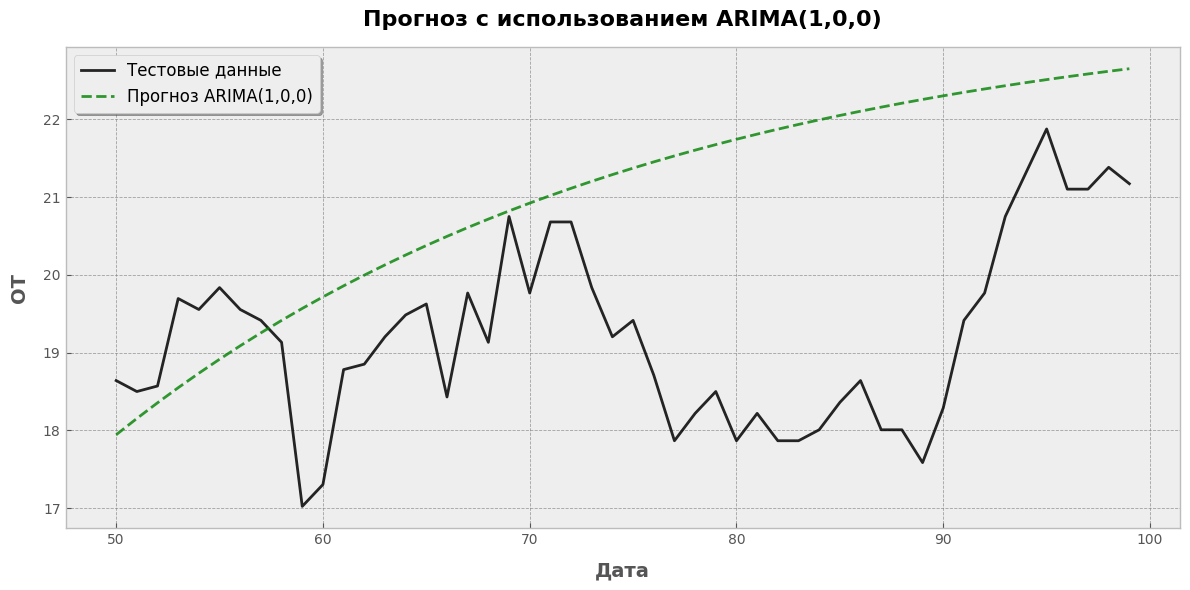

In [19]:
df = pd.read_csv('ETTm1.csv')
x = df.OT

M = 50  
N = 50  

x_train = x[:M]
x_test = x[M:M+N] 

print("\n--- Модель ARIMA для группы 1 ---")

model_arima = ARIMA(x_train, order=(1, 0, 0)).fit()
predictions_arima = model_arima.forecast(len(x_test))

mse_arima = mean_squared_error(x_test, predictions_arima)
print(f'Ошибка MSE для модели ARIMA(1,0,0): {mse_arima:.10f}')

plt.style.use('bmh')

plt.figure(figsize=(12, 6))
plt.plot(x_test, label='Тестовые данные', color='black', linewidth=2, alpha=0.85)
plt.plot(predictions_arima, label='Прогноз ARIMA(1,0,0)', color='green', linestyle='--', linewidth=2, alpha=0.8)

plt.title('Прогноз с использованием ARIMA(1,0,0)', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Дата', fontsize=14, fontweight='bold', labelpad=10)
plt.ylabel('OT', fontsize=14, fontweight='bold', labelpad=10)
plt.legend(fontsize=12, loc='best', frameon=True, shadow=True)
plt.grid(color='gray', linestyle='--', linewidth=0.6, alpha=0.7)
plt.tight_layout()
plt.show()



--- Итеративное предсказание с использованием экспоненциального сглаживания ---


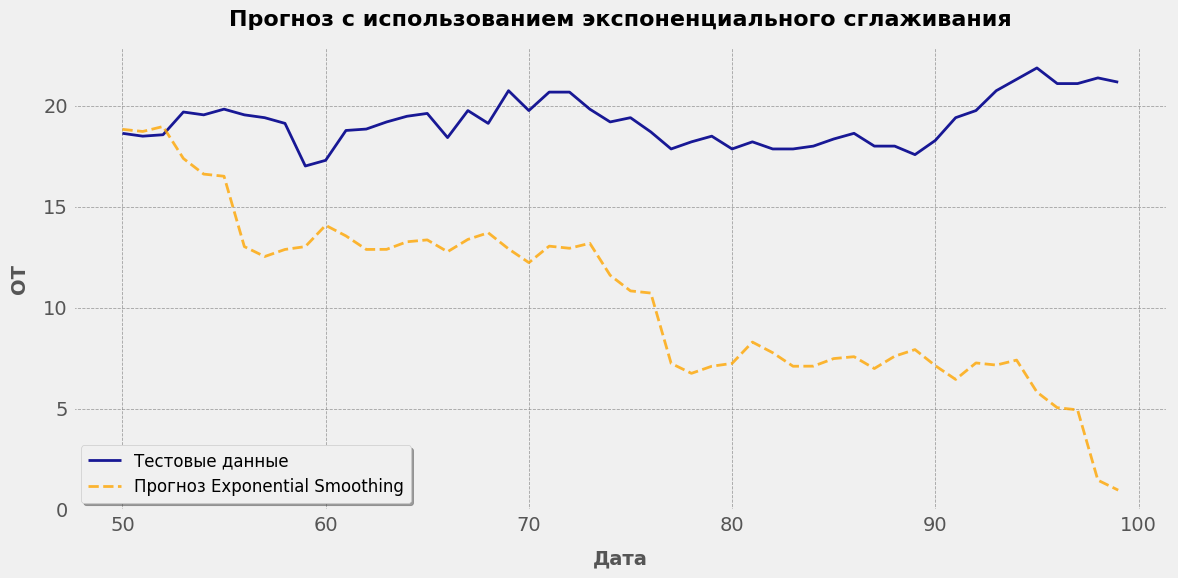

Ошибка MSE для модели Exponential Smoothing: 96.5208004445


In [20]:
print("\n--- Итеративное предсказание с использованием экспоненциального сглаживания ---")
x_train_iter = x[:M]
x_test_iter = x[M:M+N]

exp_model = ExponentialSmoothing(x_train_iter, trend='add', seasonal='add', seasonal_periods=21).fit()
exp_predictions = exp_model.forecast(len(x_test_iter))

plt.style.use('fivethirtyeight')

plt.figure(figsize=(12, 6))
plt.plot(x_test_iter, label='Тестовые данные', color='darkblue', linewidth=2, alpha=0.9)
plt.plot(exp_predictions, label='Прогноз Exponential Smoothing', color='orange', linestyle='--', linewidth=2, alpha=0.8)

plt.title('Прогноз с использованием экспоненциального сглаживания', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Дата', fontsize=14, fontweight='bold', labelpad=10)
plt.ylabel('OT', fontsize=14, fontweight='bold', labelpad=10)
plt.legend(fontsize=12, loc='best', frameon=True, shadow=True)
plt.grid(color='gray', linestyle='--', linewidth=0.6, alpha=0.7)
plt.tight_layout()
plt.show()


mse_exp = mean_squared_error(x_test_iter, exp_predictions)
print(f'Ошибка MSE для модели Exponential Smoothing: {mse_exp:.10f}')